# Scikit-learn

In [ ]:
import cv2

%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("dark")

- **Machine Learning** (ML) is important for computer vision
    - Learning
    - Inference
- **Scikit-learn** is a module for machine learning algorithms 
    - Supervised learning
    - Unsupervised learning
    - Dimensionality reduction
    - Parameter selection
    - Cross-validation
- Development leadership by researchers at INRIA, France

The computer vision field relies strongly on machine learning methods and Bayesian inference. Machine learning provides the learning and inference tools for fitting and predicting the world state from images in several vision problems. The [scikit-learn toolbox](http://jmlr.org/papers/v12/pedregosa11a.html) (or sklearn) is a machine learning package built on the SciPy Stack, developed by an international community of practitioners under the leadership of a team of researchers in INRIA, France. It provides tools for regression, classification, clustering, dimensionality reduction, parameter selection and cross-validation. Gaussian mixture models, decision trees, support vector machines, and Gaussian processes are a few examples of the methods available to date. 

## Fit/Predict

- Scikit-learn's objects implements a **fit/predict interface**
- `fit`
    - learning step (supervised or unsupervised)
- `predict`
    - regression or classification
- The learned **model** can be **stored** using Python’s built-in persistence model, `pickle`

Sklearn is able to evaluate an estimator’s performance and parameters by cross-validation, 
optionally distributing the computation to several computer cores if necessary. The sklearn module implements machine learning algorithms as objects that provide a fit/predict interface. The fit method performs learning (supervised or unsupervised, according to the algorithm). The predict method performs regression or classification. The learned model can be saved for further usage by pickle, the Python’s built-in persistence model.

## Supervised learning in Sklearn

- Nearest Neighbors
- Support Vector Machines (SVM)
    - Linear Support
    - Radial Basis Function (RGB) kernel SVM
- Decision Trees
- Ensemble
    - Random Forests
    - AdaBoost
- Linear Discriminant Analysis
- Gaussian Processes

## Unsupervised learning in Sklearn

- Gaussian mixture models
- Clustering
    - Affinity propagation
    - Mean-shift
    - Spectral clustering
    - Hierarchical clustering
    - DBSCAN
- Neural Networks (unsupervised)
    - Restricted Boltzmann machines

This tutorial will not provide a full view of all methods available in sklearn. Instead, the basic usage will be illustrated by three examples on Naïve Bayes classification, mean-shift clustering and Gaussian Mixture models. For a broad and in-depth view on this module, the reader is referred to the [sklearn on-line documentation](http://scikit-learn.org/stable/documentation.html), what is rich in descriptions, tutorials and code examples. Readers interest in machine learning and its applications in vision should refer to [Bishop's](http://research.microsoft.com/en-us/um/people/cmbishop/prml/) and [Prince's](http://www.computervisionmodels.com/) books.

## Example 6 - Skin detection using Naïve Bayes

In this example, Naïve Bayes classification is employed to detect pixels corresponding to human skin in images, based just in the pixel’s color measurements.

### Training data

- A $M \times N \times 3$ array, **color a image in CIE Lab space**
- A $M \times N$ **binary mask** representing reference classification
    - Supervised learning
- L channel is discarded, avoiding lightness influence on skin detection

Let training be a $M \times N \times 3$ array representing a color training image in the CIE Lab color space, and mask a $M \times N$ binary array representing the manual classification skin/non-skin. The Gaussian fitting for Naïve Bayes classification will just use the chromaticity data (channels 1 and 2), avoiding lightness to influence on skin detection.

In [2]:
training_bgr = cv2.imread('data/skin-training.jpg')
training_rgb = cv2.cvtColor(training_bgr, cv2.COLOR_BGR2RGB)
training = cv2.cvtColor(training_bgr, cv2.COLOR_BGR2LAB)
M, N, _ = training.shape

- The training image provides skin samples on a dark background
- Thresholding is employed to produce the binary mask

In [3]:
mask = np.zeros((M,N))
mask[training[:,:,0] > 160] = 1

<IPython.core.display.Javascript object>


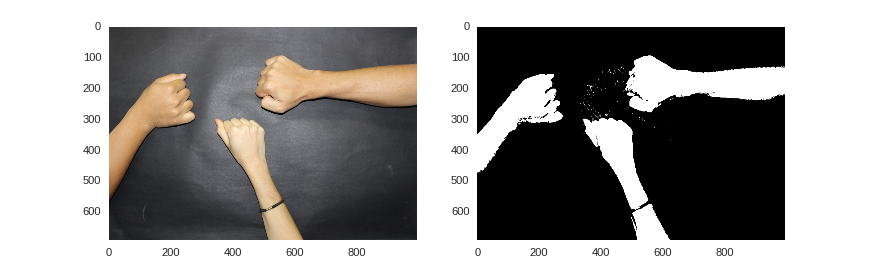

In [4]:
plt.subplot(1,2,1)
plt.imshow(training_rgb)
plt.subplot(1,2,2)
plt.imshow(mask, cmap=plt.cm.binary_r)

- Data is *reshaped* to a $MN$ vectors
- Each vector is 2-d, containing values for *a* anf *b* channels
- *Slicing* used to skip the *L* channel data

The data is composed by $MN$ 2d-vectors, easily extracted from the training image using reshaping and slicing.

In [5]:
data = training.reshape(M*N, -1)[:,1:]
data

array([[128, 129],
       [128, 129],
       [128, 129],
       ..., 
       [127, 129],
       [125, 134],
       [123, 136]], dtype=uint8)

Similarly, the manual classification used in the learning step is represented as a binary $MN$ vector:

In [6]:
target = mask.reshape(M*N)
target

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

#### Training (fitting)

- Gaussian Naïve Bayes is implemented by the `GaussianNB` object
- It presents a `fit` method for training

Sklearn provides a `naive_bayes` module containing a `GaussianNB` object that implements the supervised learning by the Gaussian Naïve Bayes method. As previously discussed, this object presents a `fit` method that performs the learning step:

In [7]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(data, target)

GaussianNB(priors=None)

#### Classification (prediction)

- Input image is converted to the CIE *Lab* color space
- Array is reshaped and sliced as the training data
- `GaussianNB.predict` is used for classification

Skin detection can be performed converting the input image to the Lab color space, and then reshaping and slicing in the same way as the training image. The predict method of GaussianNB performs the classification. The resulting classification vector can be reshaped to the original image dimensions for visualization.

In [8]:
test_bgr = cv2.imread('data/thiago.jpg')
test_rgb = cv2.cvtColor(test_bgr, cv2.COLOR_BGR2RGB)
test = cv2.cvtColor(test_bgr, cv2.COLOR_BGR2LAB)
M_tst, N_tst, _ = test.shape

In [9]:
data = test.reshape(M_tst * N_tst, -1)[:,1:]
skin_pred = gnb.predict(data)
S = skin_pred.reshape(M_tst, N_tst)

<IPython.core.display.Javascript object>


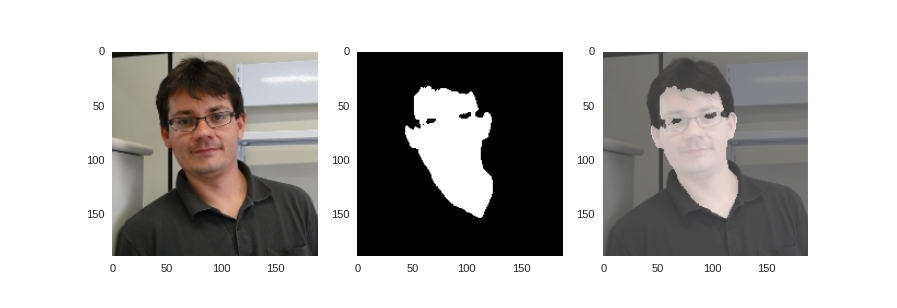

In [10]:
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.subplot(1,3,2)
plt.imshow(S, cmap=plt.cm.binary_r)
plt.subplot(1,3,3)
plt.imshow(test_rgb, alpha=0.6)
plt.imshow(S, cmap=plt.cm.binary_r, alpha=0.4)

## Example 7 - Color segmentation using mean-shift clustering

In this example, the [mean-shift algorithm](http://dx.doi.org/10.1109/34.400568) is employed to perform color segmentation, grouping similar colors together (*color quantization*).

### Mean-shift 

- The *feature vectors* are the pixels' **color triplets** in CIE *Lab* color space
- A $M \times N \times$ array is reshaped to $MN$ 3-d vectors

This clustering procedure relies in the Euclidean distance between the feature vectors, in this case the pixels’ color triplets. A perceptually uniform color space is more suitable to this task, once in such a space the Euclidean distances between triplets approximate the human perceptual differences. In this example, the *Lab* space is employed again. A view on the image is produced by reshaping, transforming the $M \times N$ array in a sequence of $M N$ 3-d vectors:

In [11]:
I = cv2.imread('data/BSD-118035.jpg')
I_Lab = cv2.cvtColor(I, cv2.COLOR_BGR2LAB)
h, w, _ = I_Lab.shape
from sklearn.cluster import MeanShift, estimate_bandwidth
X = I_Lab.reshape(h*w, -1)
X

array([[ 33, 121, 120],
       [ 33, 121, 120],
       [ 33, 121, 120],
       ..., 
       [122, 122, 118],
       [125, 122, 120],
       [ 38, 122, 126]], dtype=uint8)

- Means-shift implementation in sklearn employs a **flat kernel**
- Such a kernel is defined by a **bandwidth** parameter
- Bandwidth can be automatically selected
    - Sampling of inter-pixels color distances
        - Euclidean distance in *Lab* approximates human perception 
    - A *quantile* is selected to pick the bandwidth value

The mean-shift implementation in sklearn employs a flat kernel defined by a *bandwidth* parameter. The bandwidth can be automatically selected by sampling the color distances be
tween pixels in the input image and taking an arbitrary quantile selected by the user (larger quantiles generate bandwidths that produce fewer clusters). This procedure is implemented by the `estimate_bandwidth` function. Finally, the `fit` method is employed to perform the unsupervised learning:

In [12]:
b = estimate_bandwidth(X, quantile=0.1, n_samples=2500)
ms = MeanShift(bandwidth=b, bin_seeding=True)
ms.fit(X)

MeanShift(bandwidth=12.296007814340724, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

`bin_seeding=True` initializes the kernel locations to discretized version of points, where points are binned onto a grid whose coarseness corresponds to the bandwidth.

- `ms.labels_` keeps the cluster identification for each pixel
- `ms.cluster_centers_` stores the *cluster centers*
- The color quantization is performed attributing to each pixel the value the assigned cluster center

The `labels_` attribute keeps the cluster attributed to each pixel, and the `cluster_centers_` attribute stores the center value for each cluster. These centers are the quantized colors and will be employed on the visualization:

In [13]:
S = np.zeros_like(I)
L = ms.labels_.reshape(h, w)
num_clusters = ms.cluster_centers_.shape[0]
print num_clusters

for c in range(num_clusters):
    S[L == c] = ms.cluster_centers_[c]

9


<IPython.core.display.Javascript object>


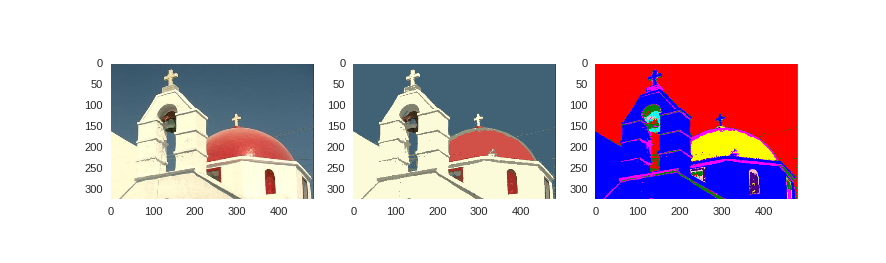

In [14]:
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(S, cv2.COLOR_LAB2RGB))

from skimage.color import label2rgb 
segments = label2rgb(L)
plt.subplot(1,3,3)
plt.imshow(segments)

In this example, just the pixel color was employed, resulting in color quantization. To perform spatial-color segmentation as [proposed by Comaniciu and Meer](http://dx.doi.org/10.1109/34.1000236), a multivariate kernel is needed. To the date, multivariate kernels are not available in sklearn’s mean-shift implementation.

## Example 8 - Background subtraction using Gaussian mixture models

The background of a video sequence is modeled using mixtures of Gaussians and further employed to classify people and objects as foreground.

Let $V$ be a $MN \times T$ array representing a video sequence composed by $T$ frames. Each frame is a $M \times N$ grayscale image. The background model is composed by M N mixtures of K multivariate Gaussians. [Stauffer and Grimson](http://dx.doi.org/10.1109/CVPR.1999.784637) proposed the use of Gaussian mixtures for background modeling because they are a simple and convenient way to represent multimodal distributions. Scenes in video sequences can present some sort of dynamic background, an issue commonly referred as the ["waving trees" problem](http://dx.doi.org/10.1109/ICCV.1999.791228), and multimodal distributions are a better way to represent this variation.

- Each frame is a $M \times N$ grayscale image
- $V$ is a $MN \times T$ array, $T$ is *time*

In [15]:
frames = !ls data/CAVIAR_LeftBag/*.jpg
# Let's find the frame dimensions, M x N
F = cv2.imread(frames[0], cv2.IMREAD_GRAYSCALE)
M, N = F.shape
T = len(frames)
M, N, T

(288, 384, 1439)

For each time $t$, insert pixels values in $V$, in the [0..1] interval:

In [16]:
num_pixels = M * N
V = np.zeros((num_pixels, T), dtype=np.float)

for t, fname in enumerate(frames):
    F = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    V[:,t] = np.array(F, dtype=float).reshape(-1)/255
    
V.shape

(110592, 1439)

In [17]:
print V[num_pixels/2]

[ 0.15294118  0.16862745  0.14117647 ...,  0.21176471  0.21960784
  0.19215686]


<IPython.core.display.Javascript object>


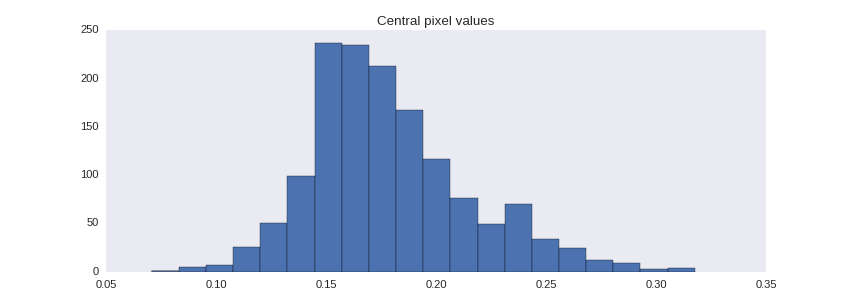

In [18]:
hist = plt.hist(V[num_pixels/2], bins=20)
plt.title('Central pixel values')

<IPython.core.display.Javascript object>


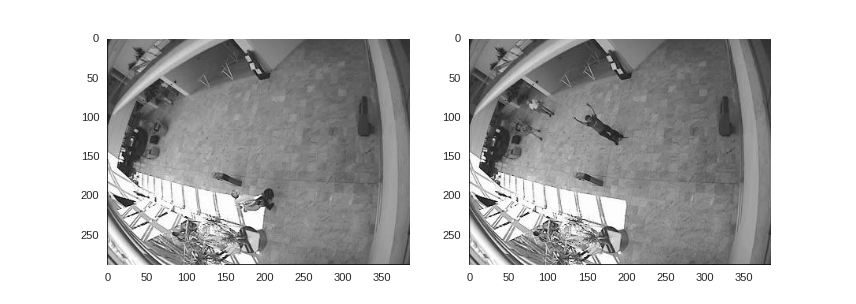

In [19]:
plt.subplot(1,2,1)
plt.imshow(V[:,0].reshape(M, N), cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(V[:,100].reshape(M, N), cmap=plt.cm.gray)

Each one of the $M N$ pixels is represented by a Gaussian mixture model (GMM). In the code below, Python’s list comprehension is used to instantiate $M N$ `GaussianMixture` objects. Three Gaussian are being used ($K = 3$), letting each model represent up to 3 modes in a background distribution. The learning is performed using frames $V_t$ constrained to the instants $t \in [600, 749]$, a segment of the input video presenting an empty scene without people or moving objects.

Each pixel has its own model: a mixture of three Gaussians.

In [20]:
from sklearn.mixture import GaussianMixture
K = 3

pixels = range(num_pixels)
gmm = [GaussianMixture(n_components=K) for p in pixels]

for p in pixels:
    gmm[p].fit(V[p,600:750].reshape(-1,1))

After fitting, the Gaussians’ means and weights can be recovered:

In [21]:
bg_mean = np.array([model.means_ for model in gmm])
bg_weight = np.array([model.weights_ for model in gmm])

<IPython.core.display.Javascript object>


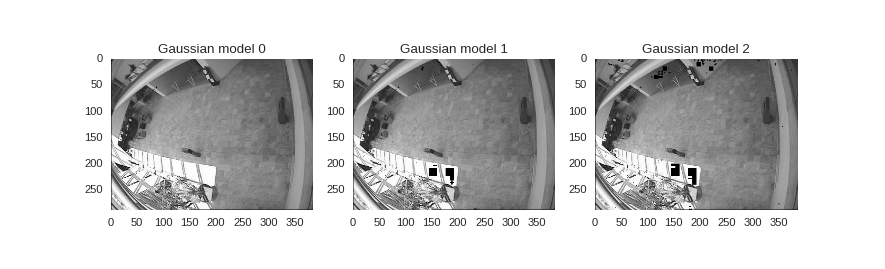

In [22]:
for k in range(K):
    plt.subplot(1, K, k+1)   
    mu = bg_mean[:,k].reshape(M, N)
    plt.imshow(mu, cmap=plt.cm.gray)
    plt.title('Gaussian model %d' % k)

For classification of a frame $V_t$ , the predict method should be called by the `GaussianMixture` object of each pixel:

In [23]:
t = 100
# Find the selected Gaussian model for each pixel p
c = np.array([gmm[p].predict(V[p,t]) for p in pixels])

`c[p]` $\in [0, 1, 2]$ is the selected Gaussian for pixel $p$. So, for each pixel, values for the mean and the standard deviation are available:

In [24]:
model_mean = np.array([gmm[p].means_[c[p]] for p in pixels]).reshape(num_pixels, 1)
model_var = np.array([gmm[p].covariances_[c[p]] for p in pixels]).reshape(num_pixels, 1)
model_stddev = np.sqrt(model_var)

Here, the prediction step just selects one of the $K$ Gaussians, $c_i$ , as the proper model to the $i$-th pixel. Note the code above also recovers the mean and the covariance matrix of $c_i$ . The pixel is declared background if (i) the weight of of $c_i$ is above a threshold selected by the user (or defined using supervised learning) and (ii) if the difference between the observed pixel and the mean of $c_i$ is under a confidence interval, defined using the covariance matrix in $c_i$. The criteria in (i) evaluates if such a Gaussian is really modeling the background distribution or if it just captured moving objects or noise.

An observed pixel value is considered *background* iff:

- the selected Gaussian presents weight greater than 0.01
- the difference to the mean is less than $12\times$ the standard deviation of the selected Gaussian

In [40]:
is_weight_enough = np.array([bg_weight[p, c[p]] for p in pixels]) > 0.01
is_inlier = np.abs(V[:,t].reshape(-1,1) - model_mean) < 12. * model_stddev

In [41]:
background = is_weight_enough & is_inlier

<IPython.core.display.Javascript object>


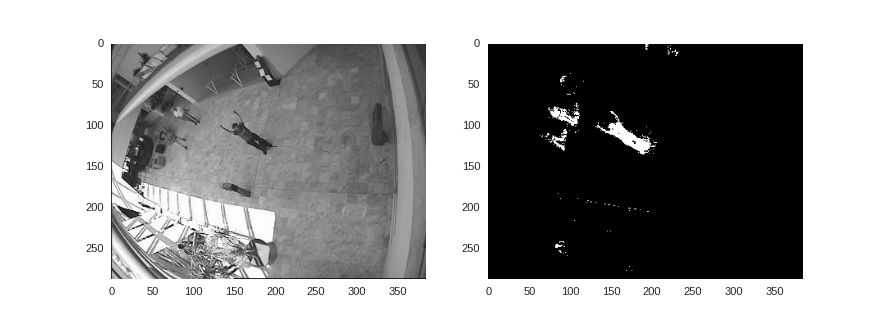

In [42]:
plt.subplot(1,2,1)
plt.imshow(V[:,t].reshape(M, N), cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(background.reshape(M, N), cmap=plt.cm.binary)